#### Задача 5. Щукина Алина



$
    \xi \sim \text{multinomial}(n, \{\mu_1, \mu_2, \mu_3, \mu_4\}) =  \text{multinomial}(n, \mu^4)
$


$
    H_0 : \mu^4 = \{0.15 ,0.20, 0.30, 0.35\}
$

$
    H_1 : \mu^4 = \left\{\frac{0.15}{1+k}+\frac{k}{1+k} ,\frac{0.20}{1+k}, \frac{0.30}{1+k}, \frac{0.35}{1+k}\right\}
$

$
~~~~~~~\text{или}~\left\{\frac{0.15}{1+k},\frac{0.20}{1+k}+\frac{k}{1+k}, \frac{0.30}{1+k}, \frac{0.35}{1+k}\right\}
$

$
~~~~~~~\text{или}~\left\{\frac{0.15}{1+k},\frac{0.20}{1+k}, \frac{0.30}{1+k}+\frac{k}{1+k}, \frac{0.35}{1+k}\right\}
$

$
~~~~~~~\text{или}~\left\{\frac{0.15}{1+k},\frac{0.20}{1+k}, \frac{0.30}{1+k}, \frac{0.35}{1+k}+\frac{k}{1+k}\right\},~~~~k > 0
$

In [10]:
from scipy.stats import multinomial
import numpy
import math

Наша статистика должна быть величиной, которая хорошо характеризует отклонение нашего значения от ожидаемого. Мы хотим выявить случаи, когда доля трафика от одного из провайдеров подозрительно большая. Давайте возьмём в качестве статистики сумму квадратов отклонений наблюдаемого трафика каждого из провайдеров от исторических значений 

$ t = \left(\dfrac{x_1}{n} - 0.15\right)^2 + \left(\dfrac{x_2}{n} - 0.20\right)^2 + \left(\dfrac{x_3}{n} - 0.30\right)^2 + \left(\dfrac{x_4}{n} - 0.35\right)^2$

In [27]:
def quad_stat(providers: list) -> float:
    """
    Эта функция считает статистику описанную выше для наблюдаемых значений трафиков
    """
    a = providers[0] / sum(providers)
    b = providers[1] / sum(providers)
    c = providers[2] / sum(providers)
    d = providers[3] / sum(providers)
    return ((a - 0.15)**2 + (b - 0.20)**2 +
                     (c - 0.30)**2 + (d - 0.35)**2)

In [24]:
numpy.random.seed(42)

n = 100
p0 = [0.15, 0.20, 0.30, 0.35]
rv0 = multinomial(n, p = p0)


H0 = [quad_stat(rv) for rv in rv0.rvs(size=10000)]
alpha = 0.05
value_critical = numpy.percentile(a=H0, q=(1-alpha) * 100)

In [25]:
def power(k: float) -> list:
    """
    Эта функция рассчитывает мощность нашей статистики, используя метод Монте-Карло
    """
    numpy.random.seed(42)
    
    n_iterations = 1000
    
    TP = [0]*4
    FN = [0]*4
    
    H1 = [0.15 /(1 + k) + k / (1 + k), 0.20/(1 + k),
               0.30/(1 + k), 0.35/(1 + k)]
        
    H2 = [0.15 /(1 + k), 0.20/(1 + k) + k / (1 + k),
               0.30/(1 + k), 0.35/(1 + k)]
        
    H3 = [0.15 /(1 + k), 0.20/(1 + k),
               0.30/(1 + k) + k / (1 + k), 0.35/(1 + k)]
        
    H4 = [0.15 /(1 + k), 0.20/(1 + k),
               0.30/(1 + k), 0.35/(1 + k) + k / (1 + k)]
    
    trafics = [H1, H2, H3, H4]

    for i in range(n_iterations):
        
        for j in range(4):

            if (quad_stat(multinomial.rvs(n=100, 
                                          p=trafics[j], size=1)[0]) >= value_critical):
                TP[j] += 1
            else:
                FN[j] += 1

    power = [TP[i] / (TP[i] + FN[i]) for i in range(4)]
    return power

Посмотрим на графики мощности нашего критерия для разных значений k от 1 до 100 процентов для всех четырёх провайдеров:

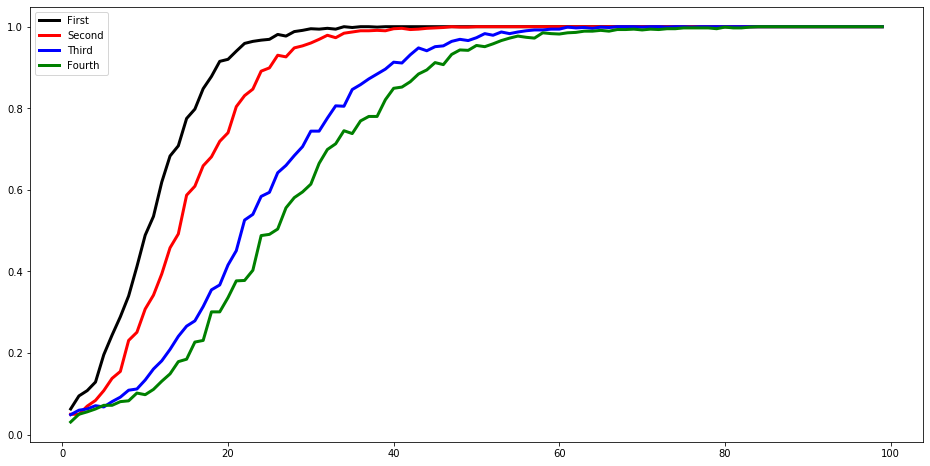

In [26]:
from matplotlib import pyplot

powers = [power(k/100) for k in range(1, 100, 1)]
powers1 = [i[0] for i in powers]
powers2 = [i[1] for i in powers]
powers3 = [i[2] for i in powers]
powers4 = [i[3] for i in powers]

pyplot.figure(figsize=(16, 8))

pyplot.plot(
    range(1, 100, 1), 
    powers1, 
    'k-', linewidth=3.0, label='First'
)

pyplot.plot(
    range(1, 100, 1), 
    powers2, 
    'r-', linewidth=3.0, label='Second'
)

pyplot.plot(
    range(1, 100, 1), 
    powers3, 
    'b-', linewidth=3.0, label='Third'
)

pyplot.plot(
    range(1, 100, 1), 
    powers4, 
    'g-', linewidth=3.0, label='Fourth'
)



pyplot.legend(loc='best', frameon=True)
pyplot.show()

По графику видно, что при подмешивании ботского трафика от четвёртого провайдера мощность нашего критерия растёт медленнее и при каждом k меньше, чем мощности остальных трёх. Это означает, что провайдеру **выгоднее подмешивать трафик через четвертый канал**, чтобы наш критерий с меньшей вероятностью обнаруживал обман. 

Интуитивно это можно объяснить тем, что при подмешивании "левых" людей в маленькую группку мы обнаружим их с большей вероятностью, чем если "чужие" люди подмешаются в большую толпу. Поэтому, поскольку через четвёртый канал провайдер пускает наибольшее количество трафика (35%), то ему логичнее использовать именно его для подмешивания ботского трафика.